In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from scipy.stats import uniform

## General classes

In [48]:
class Environment:
    def __init__(self):
        pass

    def round(self, product_price):
        pass

In [49]:
class Agent:
    def __init__(self):
        pass

    def pull_arm(self):
        pass

    def update(self, reward_t):
        pass

### Requirement 1: single product and stochastic environment

In [50]:
class SingleProductEnvironment(Environment):
  def __init__(self, T, max_valuation):
    self.T = T # Number of rounds
    self.t = 0 # Starting round

    # Valuation of each buyer sampled from the given distribution function
    self.valuation = np.random.uniform(0, max_valuation, T) 

  def round(self, p_t):
    # Check if the buyer valuation is higher than product price
    r_t = p_t if self.valuation[self.t] >= p_t else 0

    # Update round
    self.t = self.t + 1

    return r_t

In [51]:
class SingleProductUCB1(Agent):
    def __init__(self, T, prices, range=1):
        self.range = range # Range of the reward
        self.P = len(prices) # Prices' set cardinality
        self.T = T # Number of rounds
        self.pi_t = None # Init price

        self.average_rewards = np.zeros(self.P)
        self.N_pulls = np.zeros(self.P)

        self.t = 0 # Starting round

    def pull_arm(self):
        # Check if the round is less then number of prices
        if self.t < self.P:
            # then set it as product_price
            self.pi_t = self.t
        else:
            # Compute UCB1
            ucbs = self.average_rewards + self.range * np.sqrt(2 * np.log(self.T)/self.N_pulls)
            
            # Extract the price that maximizes the UCB1
            self.pi_t = np.argmax(ucbs)

        return self.pi_t

    def update(self, reward):
        self.N_pulls[self.pi_t] += 1

        # As average, we have (total purchasing) / (number of times of purchasing)
        self.average_rewards[self.pi_t] += (reward - self.average_rewards[self.pi_t])/self.N_pulls[self.pi_t]
        self.t += 1

In [52]:
T = 10000
max_valuation = 150
price_step = 5
max_price = max_valuation + price_step

prices = np.arange(0, max_price, price_step)

#### Claivoyant

In [53]:
# Linear problem
valuation = uniform(loc=0, scale=max_valuation)
#selling_prob = 1 - prices / max_valuation
selling_prob = 1 - valuation.cdf(prices)

In [54]:
# Expected revenue
expected_revenue = prices * selling_prob

# Expected utility
max_expected_revenue = np.max(expected_revenue)
optimal_price = prices[np.argmax(expected_revenue)]

expected_clairvoyant_utilities = np.full(T, max_expected_revenue)

In [55]:
# Objective function coeffiecients
c = -prices * selling_prob

# Constraints
A_eq = [np.ones(len(prices))] # matrice dei coeff dei constraint (=) - LHS
b_eq = [1] # RHS

# Resolve
res = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))

# Optimization problem value
expected_clairvoyant_utilities = np.array([-res.fun for u in range(T)])

In [56]:
n_trials = 2
regret_per_trial = []

for trial in range(n_trials):

  # Define environment and agent
  env = SingleProductEnvironment(T, max_valuation)
  ucb1_agent = SingleProductUCB1(T, prices, range=max_price)

  agent_rewards = []

  for t in range(T):
    # This returns the price index
    pi_t = ucb1_agent.pull_arm()

    # Get the actual price
    p_t = prices[pi_t]

    # Get reward
    r_t = env.round(p_t)

    # Update agent state
    ucb1_agent.update(r_t)

    agent_rewards.append(r_t)

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)

  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

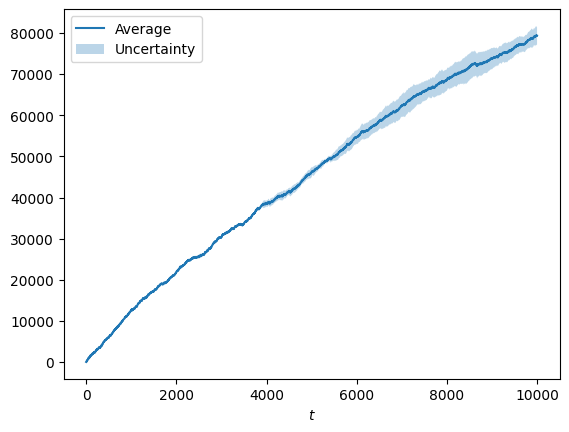

In [57]:
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

plt.plot(np.arange(T), average_regret, label="Average")
plt.fill_between(
    np.arange(T), 
    average_regret-regret_sd/np.sqrt(n_trials), 
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3,
    label="Uncertainty"
)
plt.xlabel("$t$")
plt.legend()

In [58]:
prices, res.x

(array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
        130, 135, 140, 145, 150]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]))

In [59]:
prices[np.argmax(ucb1_agent.N_pulls)]

np.int64(75)

### Requirement 2: multiple products and stochastic environment

In [ ]:
class MultipleProductEnvironment(Environment):
  def __init__(self, T, N, max_valuation):
    self.T = T # Number of buyers (rounds)
    self.N = N # Number of types of products
    self.t = 0 # Current buyer

    # Valuation of each buyer sampled from the given distribution function
    self.valuations = np.random.uniform(0, max_valuation, size=(T, N))

  def round(self, p_t):
    reward = np.array([])

    # Check if the buyer valuations are higher than products prices
    for valuation, price in zip(self.valuations[self.t, :], p_t):
      if valuation >= price:
        reward = np.append(reward, price)
      else:
        reward = np.append(reward, 0.)

    # Update round
    self.t = self.t + 1
    return reward

### Requirement 3: best-of-both-worlds algorithms with a single product

### Requirement 4: best-of-both-worlds algorithms with multiple products

### Requirement 5: slightly non-stationary environments with multiple products